In [1]:
import torch
import torchvision
import warnings
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import time
from tqdm import trange

# 1. Обработка данных

In [2]:
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
batch_size = 100

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

num_classes = 10

100%|██████████| 170498071/170498071 [00:04<00:00, 39015641.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def train(model, criterion, optimizer, num_epochs):
    for _ in trange(num_epochs):
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [5]:
def test(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Точность на тестовой выборке: {accuracy}")
    return accuracy

In [6]:
exp_models = {
    "resnet18": models.resnet18,
    "shufflenet": models.shufflenet_v2_x1_0,
    "resnet50": models.resnet50,
    "googlenet": models.googlenet,
}

experiment_types = {
    "exp1": lambda model: list(model.children())[-1],
    "exp2": lambda model: model.children(),
}

num_epochs = 5
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
results = {}
model_params = {}

In [7]:
warnings.filterwarnings("ignore")

# 2. Обучение моделей

In [8]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#Обучение моделей
for model_name, model_fn in exp_models.items():
    for experiment_name, experiment_fn in experiment_types.items():
        print(f"Обучение {model_name} с {experiment_name}")

        model = model_fn(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

        modified_layers = experiment_fn(model)
        if isinstance(modified_layers, nn.Linear):
            modified_layers = [modified_layers]

        for layer in modified_layers:
            for param in layer.parameters():
                param.requires_grad = True

        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        count_train_params = count_trainable_parameters(model)
        print("Количество обучаемых параметров:", count_train_params)
        start_time = time.time()
        train(model, criterion, optimizer, num_epochs=num_epochs)
        end_time = time.time()
        print("Время:", end_time - start_time)
        model_params[(model_name, experiment_name)] = [model, optimizer, count_train_params]
        results[(model_name, experiment_name)] = test(model)
        del model

Обучение resnet18 с exp1


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 53.6MB/s]


Количество обучаемых параметров: 5130


100%|██████████| 5/5 [07:36<00:00, 91.38s/it]

Время: 456.89772629737854


Точность на тестовой выборке: 78.5
Обучение resnet18 с exp2
Количество обучаемых параметров: 11181642


100%|██████████| 5/5 [12:09<00:00, 145.95s/it]

Время: 729.7783963680267



Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


Точность на тестовой выборке: 79.01
Обучение shufflenet с exp1


100%|██████████| 8.79M/8.79M [00:00<00:00, 102MB/s]


Количество обучаемых параметров: 10250


100%|██████████| 5/5 [07:25<00:00, 89.11s/it]

Время: 445.54512667655945


Точность на тестовой выборке: 83.6
Обучение shufflenet с exp2
Количество обучаемых параметров: 1263854


100%|██████████| 5/5 [08:05<00:00, 97.08s/it]

Время: 485.40212965011597


Точность на тестовой выборке: 87.31
Обучение resnet50 с exp1


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


Количество обучаемых параметров: 20490


100%|██████████| 5/5 [13:24<00:00, 160.88s/it]

Время: 804.4289059638977


Точность на тестовой выборке: 76.5
Обучение resnet50 с exp2
Количество обучаемых параметров: 23528522


100%|██████████| 5/5 [41:20<00:00, 496.09s/it]

Время: 2480.432968378067


Точность на тестовой выборке: 77.3
Обучение googlenet с exp1


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 104MB/s]


Количество обучаемых параметров: 10250


100%|██████████| 5/5 [07:50<00:00, 94.12s/it]

Время: 470.6164057254791


Точность на тестовой выборке: 74.61
Обучение googlenet с exp2
Количество обучаемых параметров: 5610154


100%|██████████| 5/5 [15:52<00:00, 190.53s/it]

Время: 952.6739146709442


Точность на тестовой выборке: 79.53


In [9]:
print(model_params)

{('resnet18', 'exp1'): [ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

In [10]:
warnings.filterwarnings("default")

In [11]:
print("\nРезультаты:")
for (model_name, experiment_name), accuracy in results.items():
    print(f"{model_name} с {experiment_name}: Точность = {accuracy}")


Результаты:
resnet18 с exp1: Точность = 78.5
resnet18 с exp2: Точность = 79.01
shufflenet с exp1: Точность = 83.6
shufflenet с exp2: Точность = 87.31
resnet50 с exp1: Точность = 76.5
resnet50 с exp2: Точность = 77.3
googlenet с exp1: Точность = 74.61
googlenet с exp2: Точность = 79.53


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
results[("PW1", "exp0")] = 55.53
results

{('resnet18', 'exp1'): 78.5,
 ('resnet18', 'exp2'): 79.01,
 ('shufflenet', 'exp1'): 83.6,
 ('shufflenet', 'exp2'): 87.31,
 ('resnet50', 'exp1'): 76.5,
 ('resnet50', 'exp2'): 77.3,
 ('googlenet', 'exp1'): 74.61,
 ('googlenet', 'exp2'): 79.53,
 ('PW1', 'exp0'): 55.53}

# 3. Результаты

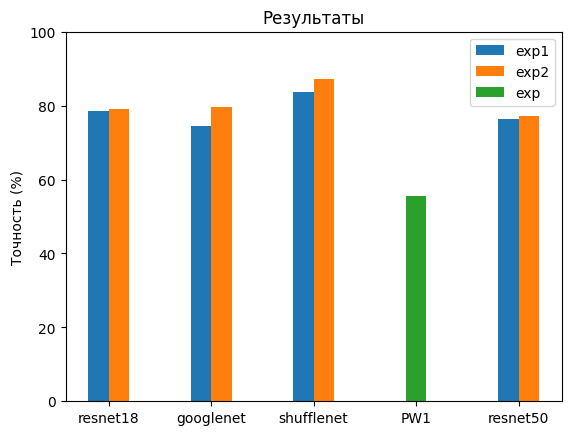

In [14]:
practice1_value = results[("PW1", "exp0")]
models = list({model for model, _ in results.keys()})
experiments = ["exp1", "exp2"]
num_models = len(models)
num_experiments = len(experiments)
bar_width = 0.2

accuracy_values = {model: [results.get((model, exp), 0) for exp in experiments] for model in models}

fig, ax = plt.subplots()
x = np.arange(num_models)

for i, experiment in enumerate(experiments):
    ax.bar(
        x + i * bar_width,
        [accuracy_values[model][i] for model in models],
        bar_width,
        label=experiment,
    )

ax.bar(3.1, practice1_value, bar_width, label="exp")

ax.legend(loc="upper right")

plt.title("Результаты")
plt.xlabel("")
plt.ylabel("Точность (%)")

plt.ylim(0, 100)
plt.xticks(x + bar_width * (num_experiments - 1) / 2, models)
plt.show()